<a href="https://colab.research.google.com/github/chaeyh4/MotionSense/blob/main/MotionSense_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SimCLR Contrastive Training for Human Activity Recognition Tutorial

In [ ]:
import 

In [ ]:
# Author: C. I. Tang
# Based on work of Tang et al.: https://arxiv.org/abs/2011.11542
# Contact: cit27@cl.cam.ac.uk
# License: GNU General Public License v3.0

%load_ext autoreload
%autoreload 2

## Imports

In [ ]:
import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
# Libraries for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.manifold

sns.set_context('poster')

In [ ]:
# Library scripts
import raw_data_processing
import data_pre_processing
import simclr_models
import simclr_utitlities
import transformations

In [ ]:
working_directory = 'test_run/'
dataset_save_path = working_directory
if not os.path.exists(working_directory):
    os.mkdir(working_directory)


## MotionSense Dataset

In this section, the MotionSense dataset will be downloaded and parsed. The results will then be saved in a python pickle file.
(Note: This section only needs to be run once)

Citation:
```
@inproceedings{Malekzadeh:2019:MSD:3302505.3310068,
author = {Malekzadeh, Mohammad and Clegg, Richard G. and Cavallaro, Andrea and Haddadi, Hamed},
title = {Mobile Sensor Data Anonymization},
booktitle = {Proceedings of the International Conference on Internet of Things Design and Implementation},
series = {IoTDI '19},
year = {2019},
isbn = {978-1-4503-6283-2},
location = {Montreal, Quebec, Canada},
pages = {49--58},
numpages = {10},
url = {http://doi.acm.org/10.1145/3302505.3310068},
doi = {10.1145/3302505.3310068},
acmid = {3310068},
publisher = {ACM},
address = {New York, NY, USA},
keywords = {adversarial training, deep learning, edge computing, sensor data privacy, time series analysis},
} 
```

### Downloading & Unzipping

In [ ]:
import requests
import zipfile

In [ ]:
dataset_url = 'https://github.com/mmalekzadeh/motion-sense/blob/master/data/B_Accelerometer_data.zip?raw=true'

r = requests.get(dataset_url, allow_redirects=True)
with open(working_directory + 'B_Accelerometer_data.zip', 'wb') as f:
    f.write(r.content)

In [ ]:

with zipfile.ZipFile(working_directory + 'B_Accelerometer_data.zip', 'r') as zip_ref:
    zip_ref.extractall(working_directory)

### Data Processing

In [ ]:
accelerometer_data_folder_path = working_directory + 'B_Accelerometer_data/'
user_datasets = raw_data_processing.process_motion_sense_accelerometer_files(accelerometer_data_folder_path)

test_run/B_Accelerometer_data/dws_1
test_run/B_Accelerometer_data/dws_11
test_run/B_Accelerometer_data/dws_2
test_run/B_Accelerometer_data/jog_16
test_run/B_Accelerometer_data/jog_9
test_run/B_Accelerometer_data/sit_13
test_run/B_Accelerometer_data/sit_5
test_run/B_Accelerometer_data/std_14
test_run/B_Accelerometer_data/std_6
test_run/B_Accelerometer_data/ups_12
test_run/B_Accelerometer_data/ups_3
test_run/B_Accelerometer_data/ups_4
test_run/B_Accelerometer_data/wlk_15
test_run/B_Accelerometer_data/wlk_7
test_run/B_Accelerometer_data/wlk_8


In [ ]:
with open(working_directory + 'motion_sense_user_split.pkl', 'wb') as f:
    pickle.dump({
        'user_split': user_datasets,
    }, f)

## Pre-processing

In [ ]:
# Parameters
window_size = 400
input_shape = (window_size, 3)

# Dataset Metadata 
transformation_multiple = 1
dataset_name = 'motion_sense.pkl'
dataset_name_user_split = 'motion_sense_user_split.pkl'

label_list = ['null', 'sit', 'std', 'wlk', 'ups', 'dws', 'jog']
label_list_full_name = ['null', 'sitting', 'standing', 'walking', 'walking upstairs', 'walking downstairs', 'jogging']
has_null_class = True

label_map = dict([(l, i) for i, l in enumerate(label_list)])

output_shape = len(label_list)

model_save_name = f"motionsense_acc"

sampling_rate = 50.0
unit_conversion = scipy.constants.g

# a fixed user-split
test_users_fixed = [1, 14, 19, 23, 6]
def get_fixed_split_users(har_users):
    # test_users = har_users[0::5]
    test_users = test_users_fixed
    train_users = [u for u in har_users if u not in test_users]
    return (train_users, test_users)

In [ ]:
with open(dataset_save_path + dataset_name_user_split, 'rb') as f:
    dataset_dict = pickle.load(f)
    user_datasets = dataset_dict['user_split']


In [ ]:
har_users = list(user_datasets.keys())
train_users, test_users = get_fixed_split_users(har_users)
print(f'Testing: {test_users}, Training: {train_users}')

Testing: [1, 14, 19, 23, 6], Training: [10, 11, 12, 13, 15, 16, 17, 18, 2, 20, 21, 22, 24, 3, 4, 5, 7, 8, 9]


Here we convert the original dataset into a windowed one, and split it into training, validation and testing sets. 

In [ ]:
np_train, np_val, np_test = data_pre_processing.pre_process_dataset_composite(
    user_datasets=user_datasets, 
    label_map=label_map, 
    output_shape=output_shape, 
    train_users=train_users, 
    test_users=test_users, 
    window_size=window_size, 
    shift=window_size//2, 
    normalise_dataset=True, 
    verbose=1
)



Test
(array(['dws', 'jog', 'sit', 'std', 'ups', 'wlk'], dtype='<U3'), array([112, 133, 360, 335, 148, 331]))
(array([1, 2, 3, 4, 5, 6]), array([360, 335, 331, 148, 112, 133]))
-----------------
Train
(array(['dws', 'jog', 'sit', 'std', 'ups', 'wlk'], dtype='<U3'), array([ 449,  480, 1282, 1146,  546, 1308]))
(array([1, 2, 3, 4, 5, 6]), array([1282, 1146, 1308,  546,  449,  480]))
-----------------
Training data shape: (4168, 400, 3)
Validation data shape: (1043, 400, 3)
Testing data shape: (1419, 400, 3)


In [ ]:
np_train[0].shape

(4168, 400, 3)

An alternative processing pipeline can be used to retain the user id as a feature and/or a label in the output dataset.

Note: This is not used in the study, and thus is commented in this notebook.

In [ ]:
# user_datasets_processed = data_pre_processing.pre_process_dataset_composite_in_user_format(
#     user_datasets=user_datasets, 
#     label_map=label_map, 
#     output_shape=output_shape, 
#     train_users=train_users, 
#     window_size=window_size, 
#     shift=window_size//2, 
#     normalise_dataset=True, 
#     verbose=1
# )

# user_datasets_with_user_ids, user_id_mapping = data_pre_processing.add_user_id_to_windowed_dataset(
#     user_datasets_processed, 
#     encode_user_id=True, 
#     as_feature=True, 
#     as_label=False, 
#     verbose=1
# )

# train_x, train_y, test_x, test_y = data_pre_processing.combine_windowed_dataset(user_datasets_with_user_ids, train_users)
# train_x_split, val_x_split, train_y_split, val_y_split = sklearn.model_selection.train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# np_train = (train_x_split, train_y_split)
# np_val = (val_x_split, val_y_split)
# np_test = (test_x, test_y)

# print("Training data shape:", train_x_split.shape)
# print("Validation data shape:", val_x_split.shape)
# print("Testing data shape:", test_x.shape)

# 센서데이터 시각화

임의의 데이터 선택 (train set 중)

In [ ]:
import random

In [ ]:
num = random.randint(0,np_train[0].shape[0])

In [ ]:
np_train[0][num]

array([[0.57418916, 0.24255642, 0.2086199 ],
       [0.578253  , 0.23597695, 0.22236678],
       [0.57561183, 0.23927766, 0.22778169],
       ...,
       [0.20697614, 0.2674866 , 0.6491479 ],
       [0.2118856 , 0.26600324, 0.65512828],
       [0.2291242 , 0.26758225, 0.64718434]])

데이터프레임화

In [ ]:
import pandas as pd

In [ ]:
train_df = pd.DataFrame(data = np_train[0][num], columns = ("x","y","z"))

In [ ]:
train_df

,x,y,z
0,0.574189,0.242556,0.208620
1,0.578253,0.235977,0.222367
2,0.575612,0.239278,0.227782
3,0.573747,0.241288,0.215047
4,0.577643,0.245547,0.222396
...,...,...,...
395,0.220792,0.258946,0.642692
396,0.217982,0.254568,0.644595
397,0.206976,0.267487,0.649148
398,0.211886,0.266003,0.655128


## **원본 데이터 시각화**

x, y, z축을 한번에 나타낸 그래프

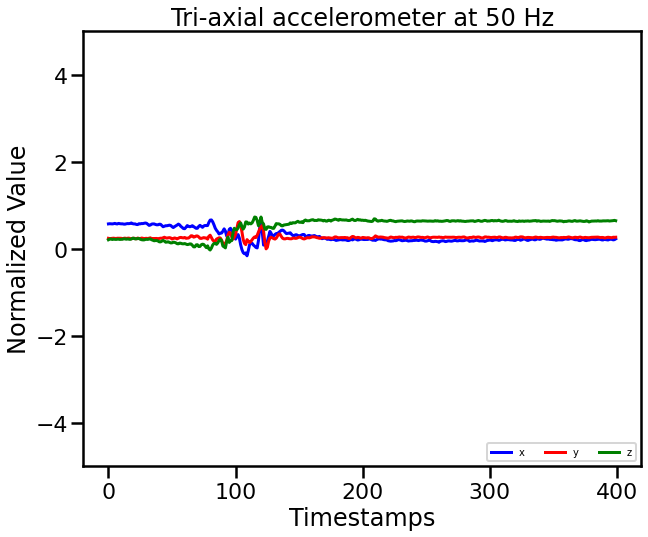

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(train_df['x'],label='x', color='b')
plt.plot(train_df['y'],label='y', color='r')
plt.plot(train_df['z'],label='z', color='g')
plt.title('Tri-axial accelerometer at 50 Hz')
plt.xlabel('Timestamps')
plt.ylabel('Normalized Value')
plt.ylim(-5,5)
plt.legend(loc='lower right', ncol=3,fontsize = 10)
plt.show()

각 축을 나눈 그래프

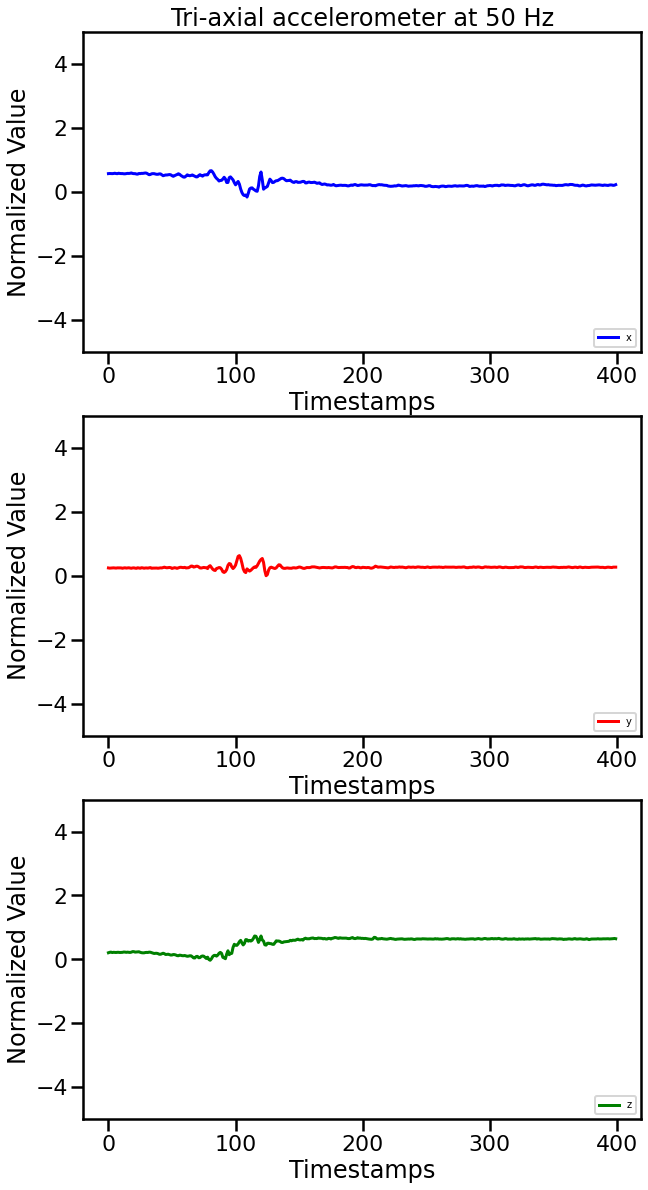

In [ ]:
plt.figure(figsize=(10,20))
plt.subplot(3,1,1)
plt.title('Tri-axial accelerometer at 50 Hz')
plt.plot(train_df['x'],label = 'x', color='b')
plt.ylim(-5,5)
plt.xlabel('Timestamps')
plt.ylabel('Normalized Value')
plt.legend(loc='lower right', ncol=3,fontsize = 10)
plt.subplot(3,1,2)
plt.plot(train_df['y'],label = 'y', color='r')
plt.ylim(-5,5)
plt.xlabel('Timestamps')
plt.ylabel('Normalized Value')
plt.legend(loc='lower right', ncol=3,fontsize = 10)
plt.subplot(3,1,3)
plt.plot(train_df['z'],label = 'z', color='g')
plt.ylim(-5,5)
plt.xlabel('Timestamps')
plt.ylabel('Normalized Value')
plt.legend(loc='lower right', ncol=3,fontsize = 10)
plt.show()


## Augmentation 데이터 시각화

Transform 라이브러리 기능

In [ ]:
# trasnform_funcs_vectorized = [
#     transformations.noise_transform_vectorized, 
#     transformations.scaling_transform_vectorized, 
#     transformations.rotation_transform_vectorized, 
#     transformations.negate_transform_vectorized, 
#     transformations.time_flip_transform_vectorized, 
#     transformations.time_segment_permutation_transform_improved, 
#     transformations.time_warp_transform_low_cost, 
#     transformations.channel_shuffle_transform_vectorized
# ]
# transform_funcs_names = ['noised', 'scaled', 'rotated', 'negated', 'time_flipped', 'permuted', 'time_warped', 'channel_shuffled']

Augmentation 진행

In [ ]:
noised = transformations.noise_transform_vectorized(np_train[0])
noised_df = pd.DataFrame(data = noised[num], columns = ("x","y","z"))

In [ ]:
scaled = transformations.scaling_transform_vectorized(np_train[0])
scaled_df = pd.DataFrame(data = scaled[num], columns = ("x","y","z"))

In [ ]:
rotated = transformations.rotation_transform_vectorized(np_train[0])
rotated_df = pd.DataFrame(data = rotated[num], columns = ("x","y","z"))

In [ ]:
negated = transformations.negate_transform_vectorized(np_train[0])
negated_df = pd.DataFrame(data = negated[num], columns = ("x","y","z"))

In [ ]:
time_flipped = transformations.time_flip_transform_vectorized(np_train[0])
time_flipped_df = pd.DataFrame(data = time_flipped[num], columns = ("x","y","z"))

In [ ]:
permuted = transformations.time_segment_permutation_transform_improved(np_train[0])
permuted_df = pd.DataFrame(data = permuted[num], columns = ("x","y","z"))

/content/transformations.py:132: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  splitted = np.array(np.split(sample, np.append(segments, X.shape[1])))


In [ ]:
time_warped = transformations.time_warp_transform_low_cost(np_train[0])
time_warped_df = pd.DataFrame(data = time_warped[num], columns = ("x","y","z"))

In [ ]:
channel_shuffled = transformations.channel_shuffle_transform_vectorized(np_train[0])
channel_shuffled_df = pd.DataFrame(data = channel_shuffled[num], columns = ("x","y","z"))

Augmentation 결과 시각화

축 한번에 시각화

In [ ]:
title = ['Noised', 'Scaled', 'Rotated', 'Negated', 'Time_flipped', 'Permuted', 'Time_warped', 'Channel_shuffled']
dataframe_title = [noised_df, scaled_df, rotated_df, negated_df, time_flipped_df, permuted_df, time_warped_df, channel_shuffled_df]

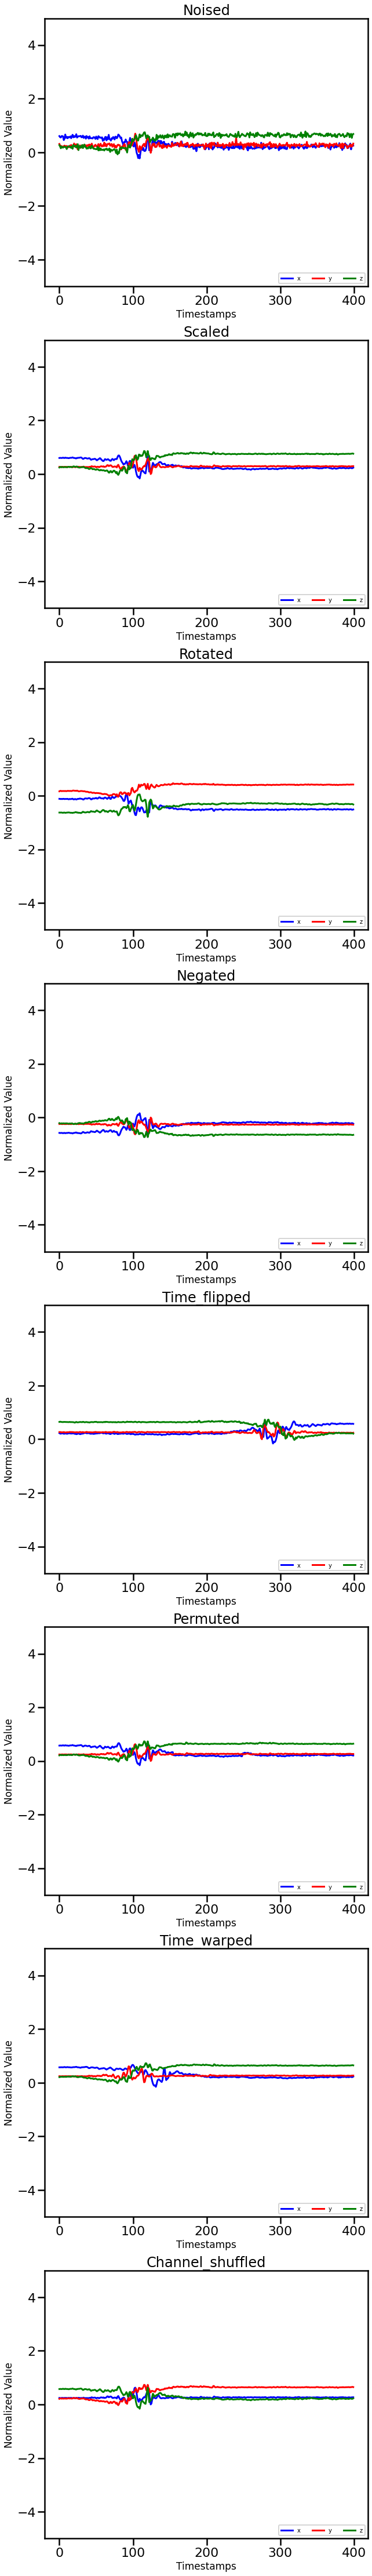

In [ ]:
plt.figure(figsize=(10,80))
for i in range(8):
  plt.subplot(8,1,i+1)
  plt.plot(dataframe_title[i]['x'],label='x', color='b')
  plt.plot(dataframe_title[i]['y'],label='y', color='r')
  plt.plot(dataframe_title[i]['z'],label='z', color='g')
  plt.title(title[i])
  plt.xlabel('Timestamps',fontsize=17)
  plt.ylabel('Normalized Value',fontsize=17)
  plt.ylim(-5,5)
  plt.legend(loc='lower right', ncol=3,fontsize = 10)
plt.show()

축 나눠서 시각화

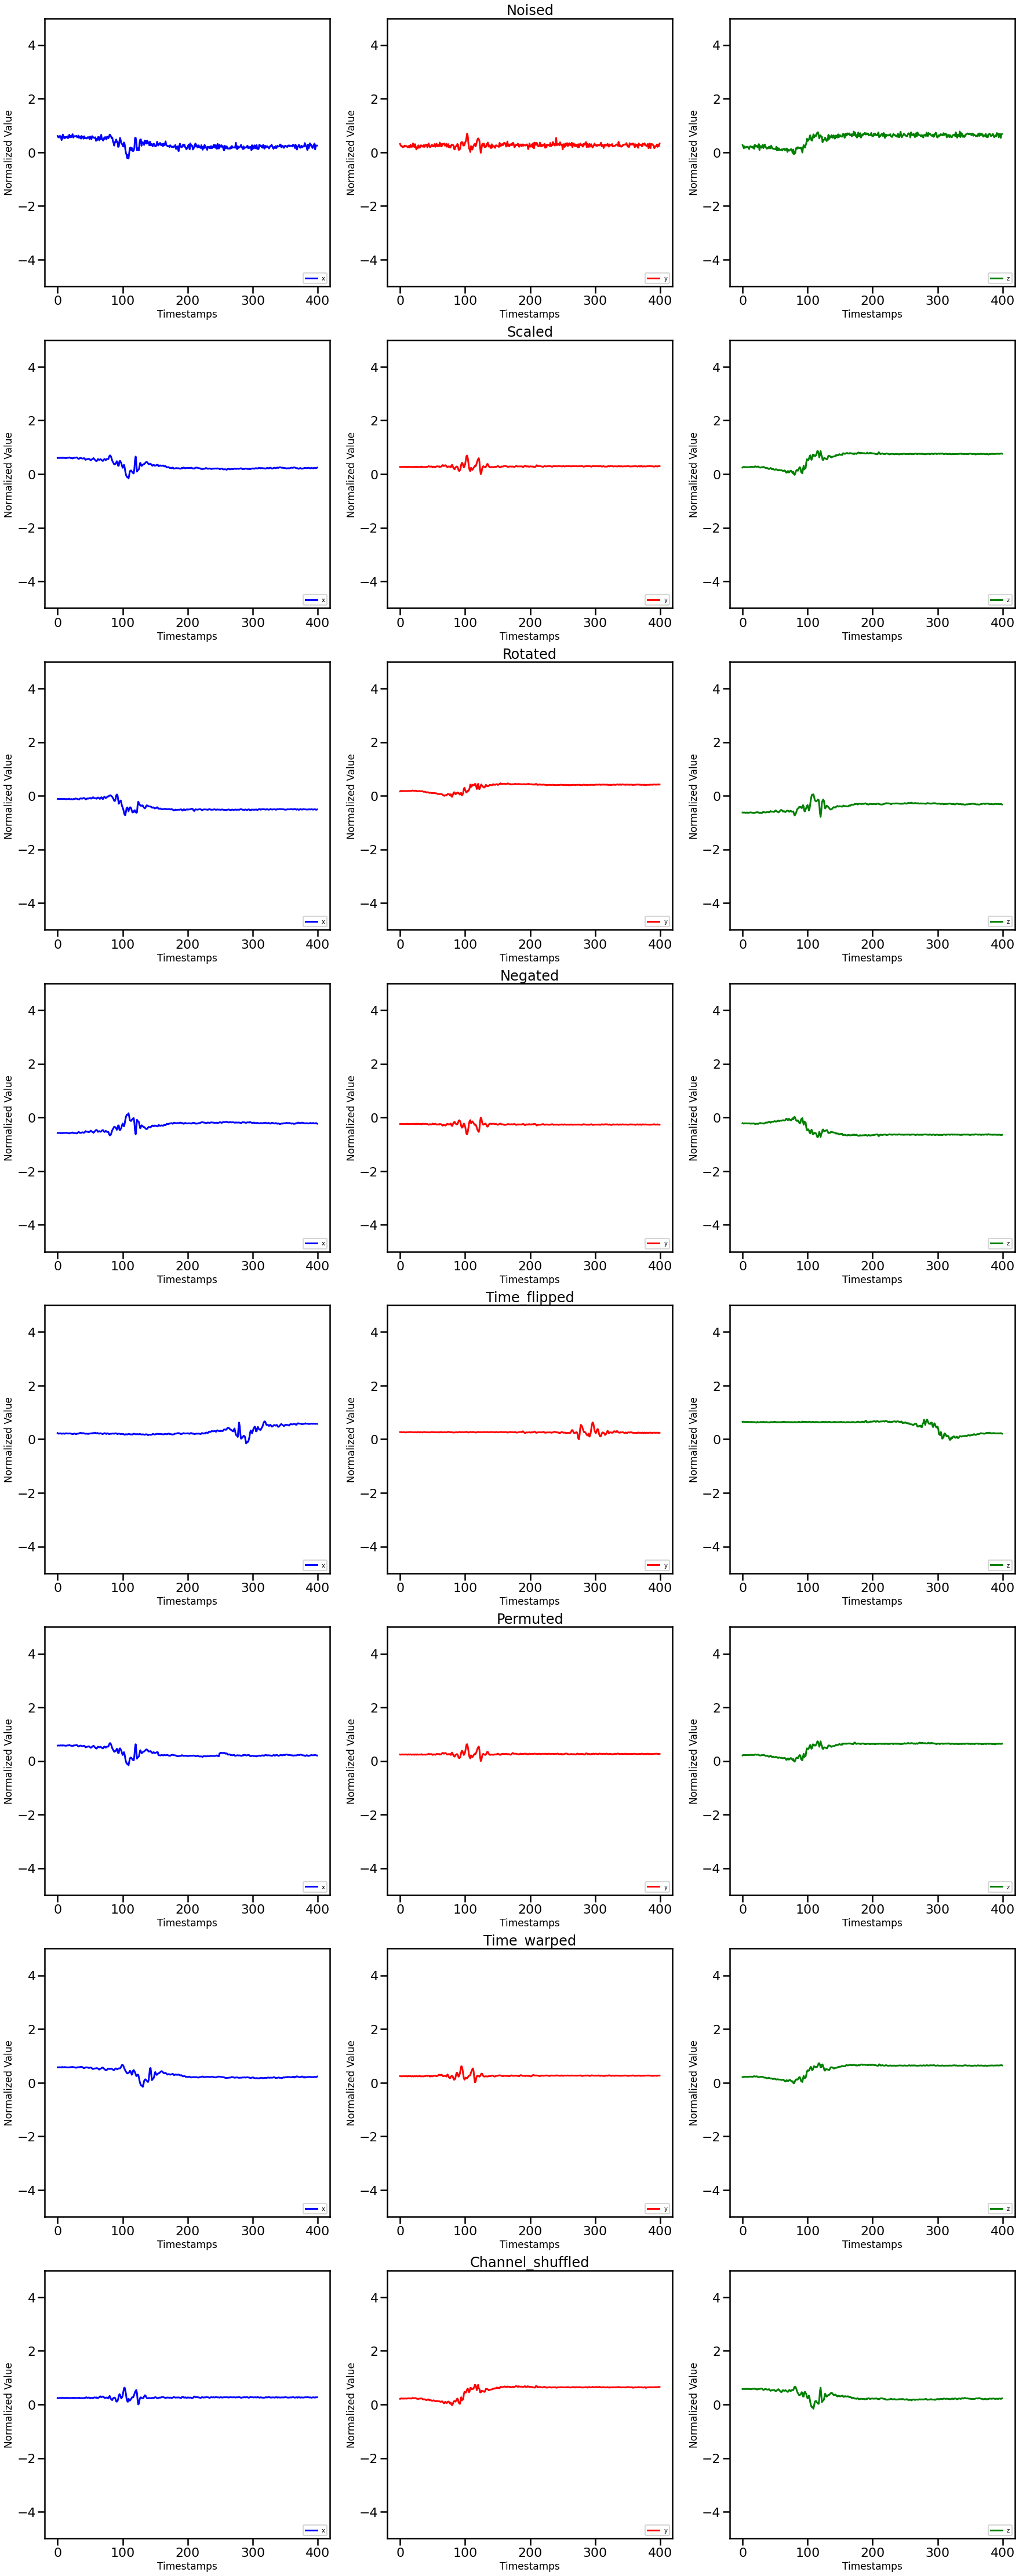

In [ ]:
plt.figure(figsize=(30,80))
for i in range(8):
  plt.subplot(8,3,i*3+1)
  plt.plot(dataframe_title[i]['x'],label = 'x', color='b')
  plt.ylim(-5,5)
  plt.xlabel('Timestamps', fontsize = 17)
  plt.ylabel('Normalized Value', fontsize = 17)
  plt.legend(loc='lower right', ncol=3,fontsize = 10)
  plt.subplot(8,3,i*3+2)
  plt.title(title[i])
  plt.plot(dataframe_title[i]['y'],label = 'y', color='r')
  plt.ylim(-5,5)
  plt.xlabel('Timestamps', fontsize = 17)
  plt.ylabel('Normalized Value', fontsize = 17)
  plt.legend(loc='lower right', ncol=3,fontsize = 10)
  plt.subplot(8,3,i*3+3)
  plt.plot(dataframe_title[i]['z'],label = 'z', color='g')
  plt.ylim(-5,5)
  plt.xlabel('Timestamps', fontsize = 17)
  plt.ylabel('Normalized Value', fontsize = 17)
  plt.legend(loc='lower right', ncol=3,fontsize = 10)
plt.show()


SimCLR처럼 Transformation 적용 (2개의 transformation 적용)

In [ ]:
#title = ['Noised', 'Scaled', 'Rotated', 'Negated', 'Time_flipped', 'Permuted', 'Time_warped', 'Channel_shuffled']
#dataframe_title = [noised_df, scaled_df, rotated_df, negated_df, time_flipped_df, permuted_df, time_warped_df, channel_shuffled_df]
# trasnform_funcs_vectorized = [
#     transformations.noise_transform_vectorized, 
#     transformations.scaling_transform_vectorized, 
#     transformations.rotation_transform_vectorized, 
#     transformations.negate_transform_vectorized, 
#     transformations.time_flip_transform_vectorized, 
#     transformations.time_segment_permutation_transform_improved, 
#     transformations.time_warp_transform_low_cost, 
#     transformations.channel_shuffle_transform_vectorized
# ]

In [ ]:
trasnform_funcs_vectorized = [
     transformations.noise_transform_vectorized, 
     transformations.scaling_transform_vectorized, 
     transformations.rotation_transform_vectorized, 
     transformations.negate_transform_vectorized, 
     transformations.time_flip_transform_vectorized, 
     transformations.time_segment_permutation_transform_improved, 
     transformations.time_warp_transform_low_cost, 
     transformations.channel_shuffle_transform_vectorized
]

In [ ]:
def SimCLR(data):
  num1 = random.randint(0,7)
  num2 = random.randint(0,7)
  trans1 = trasnform_funcs_vectorized[num1](data)
  trans2 = trasnform_funcs_vectorized[num2](trans1)
  return title[num1],title[num2],trans2

In [ ]:
simclr = SimCLR(np_train[0])

In [ ]:
print('First Transformation: '+simclr[0]+'\nSecond Transformation: '+simclr[1])

First Transformation: Channel_shuffled
Second Transformation: Scaled


In [ ]:
simclr_data = simclr[2][num]
simclr_df = pd.DataFrame(data = simclr_data, columns = ['x','y','z'])

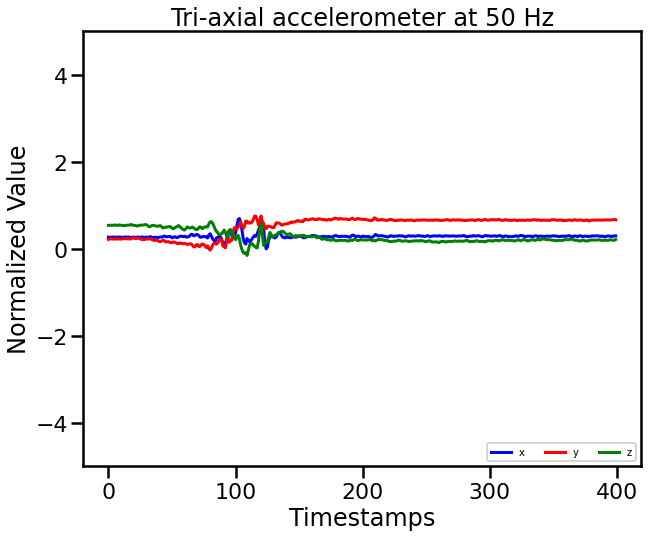

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(simclr_df['x'],label='x', color='b')
plt.plot(simclr_df['y'],label='y', color='r')
plt.plot(simclr_df['z'],label='z', color='g')
plt.title('Tri-axial accelerometer at 50 Hz')
plt.xlabel('Timestamps')
plt.ylabel('Normalized Value')
plt.ylim(-5,5)
plt.legend(loc='lower right', ncol=3,fontsize = 10)
plt.show()

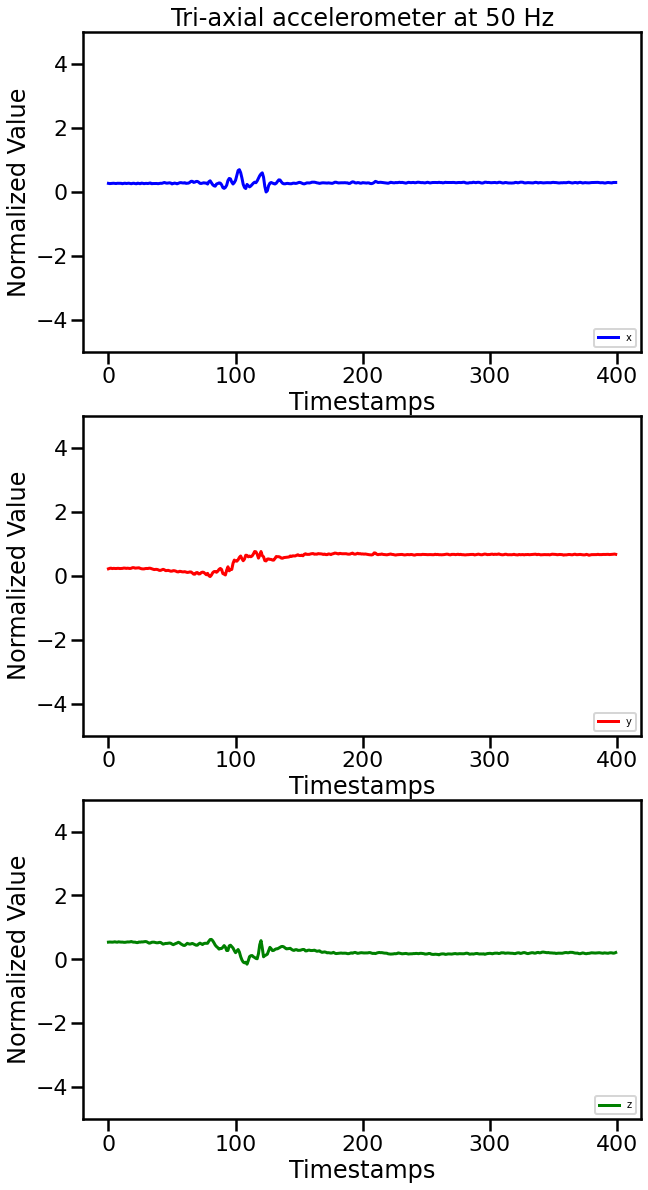

In [ ]:
plt.figure(figsize=(10,20))
plt.subplot(3,1,1)
plt.title('Tri-axial accelerometer at 50 Hz')
plt.plot(simclr_df['x'],label = 'x', color='b')
plt.ylim(-5,5)
plt.xlabel('Timestamps')
plt.ylabel('Normalized Value')
plt.legend(loc='lower right', ncol=3,fontsize = 10)
plt.subplot(3,1,2)
plt.plot(simclr_df['y'],label = 'y', color='r')
plt.ylim(-5,5)
plt.xlabel('Timestamps')
plt.ylabel('Normalized Value')
plt.legend(loc='lower right', ncol=3,fontsize = 10)
plt.subplot(3,1,3)
plt.plot(simclr_df['z'],label = 'z', color='g')
plt.ylim(-5,5)
plt.xlabel('Timestamps')
plt.ylabel('Normalized Value')
plt.legend(loc='lower right', ncol=3,fontsize = 10)
plt.show()

# SimCLR

## SimCLR Training

In [ ]:
batch_size = 512
decay_steps = 1000
epochs = 200
temperature = 0.1
transform_funcs = [
    # transformations.scaling_transform_vectorized, # Use Scaling trasnformation
    transformations.rotation_transform_vectorized # Use rotation trasnformation
]
transformation_function = simclr_utitlities.generate_composite_transform_function_simple(transform_funcs)

# trasnformation_indices = [2] # Use rotation trasnformation only
# trasnformation_indices = [1, 2] # Use Scaling and rotation trasnformation

# trasnform_funcs_vectorized = [
#     transformations.noise_transform_vectorized, 
#     transformations.scaling_transform_vectorized, 
#     transformations.rotation_transform_vectorized, 
#     transformations.negate_transform_vectorized, 
#     transformations.time_flip_transform_vectorized, 
#     transformations.time_segment_permutation_transform_improved, 
#     transformations.time_warp_transform_low_cost, 
#     transformations.channel_shuffle_transform_vectorized
# ]
# transform_funcs_names = ['noised', 'scaled', 'rotated', 'negated', 'time_flipped', 'permuted', 'time_warped', 'channel_shuffled']



0 <function rotation_transform_vectorized at 0x7fc9293794c0>


In [ ]:
start_time = datetime.datetime.now()
start_time_str = start_time.strftime("%Y%m%d-%H%M%S")
tf.keras.backend.set_floatx('float32')

lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)
# transformation_function = simclr_utitlities.generate_combined_transform_function(trasnform_funcs_vectorized, indices=trasnformation_indices)

base_model = simclr_models.create_base_model(input_shape, model_name="base_model")
simclr_model = simclr_models.attach_simclr_head(base_model)
simclr_model.summary()

trained_simclr_model, epoch_losses = simclr_utitlities.simclr_train_model(simclr_model, np_train[0], optimizer, batch_size, transformation_function, temperature=temperature, epochs=epochs, is_trasnform_function_vectorized=True, verbose=1)

simclr_model_save_path = f"{working_directory}{start_time_str}_simclr.hdf5"
trained_simclr_model.save(simclr_model_save_path)



In [ ]:
plt.figure(figsize=(12,8))
plt.plot(epoch_losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

## Fine-tuning and Evaluation

### Linear Model

In [ ]:

total_epochs = 50
batch_size = 200
tag = "linear_eval"

simclr_model = tf.keras.models.load_model(simclr_model_save_path)
linear_evaluation_model = simclr_models.create_linear_model_from_base_model(simclr_model, output_shape, intermediate_layer=7)

linear_eval_best_model_file_name = f"{working_directory}{start_time_str}_simclr_{tag}.hdf5"
best_model_callback = tf.keras.callbacks.ModelCheckpoint(linear_eval_best_model_file_name,
    monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=0
)

training_history = linear_evaluation_model.fit(
    x = np_train[0],
    y = np_train[1],
    batch_size=batch_size,
    shuffle=True,
    epochs=total_epochs,
    callbacks=[best_model_callback],
    validation_data=np_val
)

linear_eval_best_model = tf.keras.models.load_model(linear_eval_best_model_file_name)

print("Model with lowest validation Loss:")
print(simclr_utitlities.evaluate_model_simple(linear_eval_best_model.predict(np_test[0]), np_test[1], return_dict=True))
print("Model in last epoch")
print(simclr_utitlities.evaluate_model_simple(linear_evaluation_model.predict(np_test[0]), np_test[1], return_dict=True))


Epoch 1/50
21/21 [==============================] - 2s 40ms/step - loss: 1.5929 - categorical_accuracy: 0.5003 - auc: 0.7834 - precision: 0.6352 - recall: 0.3418 - val_loss: 0.8596 - val_categorical_accuracy: 0.7852 - val_auc: 0.9484 - val_precision: 0.7807 - val_recall: 0.5187
Epoch 2/50
21/21 [==============================] - 0s 15ms/step - loss: 0.9289 - categorical_accuracy: 0.7364 - auc: 0.9311 - precision: 0.7709 - recall: 0.4958 - val_loss: 0.6866 - val_categorical_accuracy: 0.8102 - val_auc: 0.9729 - val_precision: 0.8610 - val_recall: 0.5465
Epoch 3/50
21/21 [==============================] - 0s 15ms/step - loss: 0.6992 - categorical_accuracy: 0.7940 - auc: 0.9617 - precision: 0.8519 - recall: 0.6823 - val_loss: 0.8440 - val_categorical_accuracy: 0.6711 - val_auc: 0.9446 - val_precision: 0.7531 - val_recall: 0.5264
Epoch 4/50
21/21 [==============================] - 0s 15ms/step - loss: 0.6927 - categorical_accuracy: 0.7748 - auc: 0.9606 - precision: 0.8347 - recall: 0.7208 -

### Full HAR Model

In [ ]:

total_epochs = 50
batch_size = 200
tag = "full_eval"

simclr_model = tf.keras.models.load_model(simclr_model_save_path)
full_evaluation_model = simclr_models.create_full_classification_model_from_base_model(simclr_model, output_shape, model_name="TPN", intermediate_layer=7, last_freeze_layer=4)

full_eval_best_model_file_name = f"{working_directory}{start_time_str}_simclr_{tag}.hdf5"
best_model_callback = tf.keras.callbacks.ModelCheckpoint(full_eval_best_model_file_name,
    monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=0
)

training_history = full_evaluation_model.fit(
    x = np_train[0],
    y = np_train[1],
    batch_size=batch_size,
    shuffle=True,
    epochs=total_epochs,
    callbacks=[best_model_callback],
    validation_data=np_val
)

full_eval_best_model = tf.keras.models.load_model(full_eval_best_model_file_name)

print("Model with lowest validation Loss:")
print(simclr_utitlities.evaluate_model_simple(full_eval_best_model.predict(np_test[0]), np_test[1], return_dict=True))
print("Model in last epoch")
print(simclr_utitlities.evaluate_model_simple(full_evaluation_model.predict(np_test[0]), np_test[1], return_dict=True))


Epoch 1/50
21/21 [==============================] - 2s 41ms/step - loss: 1.2525 - categorical_accuracy: 0.5996 - auc: 0.8578 - precision: 0.7691 - recall: 0.4609 - val_loss: 0.4262 - val_categorical_accuracy: 0.8648 - val_auc: 0.9898 - val_precision: 0.9042 - val_recall: 0.8140
Epoch 2/50
21/21 [==============================] - 0s 19ms/step - loss: 0.3613 - categorical_accuracy: 0.8753 - auc: 0.9895 - precision: 0.9097 - recall: 0.8363 - val_loss: 0.2751 - val_categorical_accuracy: 0.9367 - val_auc: 0.9974 - val_precision: 0.9578 - val_recall: 0.8926
Epoch 3/50
21/21 [==============================] - 0s 19ms/step - loss: 0.2203 - categorical_accuracy: 0.9421 - auc: 0.9970 - precision: 0.9571 - recall: 0.9155 - val_loss: 0.1963 - val_categorical_accuracy: 0.9674 - val_auc: 0.9986 - val_precision: 0.9800 - val_recall: 0.9377
Epoch 4/50
21/21 [==============================] - 0s 19ms/step - loss: 0.1621 - categorical_accuracy: 0.9547 - auc: 0.9985 - precision: 0.9630 - recall: 0.9435 -

## Extra: t-SNE Plots

### Parameters

In [ ]:
# Select a model from which the intermediate representations are extracted
target_model = simclr_model 
perplexity = 30.0


### t-SNE Representations

In [ ]:
intermediate_model = simclr_models.extract_intermediate_model_from_base_model(target_model, intermediate_layer=7)
intermediate_model.summary()

embeddings = intermediate_model.predict(np_test[0], batch_size=600)
tsne_model = sklearn.manifold.TSNE(perplexity=perplexity, verbose=1, random_state=42)
tsne_projections = tsne_model.fit_transform(embeddings)



Model: "base_model_simclr_layer_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 400, 3)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 377, 32)           2336      
_________________________________________________________________
dropout (Dropout)            (None, 377, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 362, 64)           32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 362, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 355, 96)           49248     
_________________________________________________________________
dropout_2 (Dropout)          (None, 355, 

### Plotting

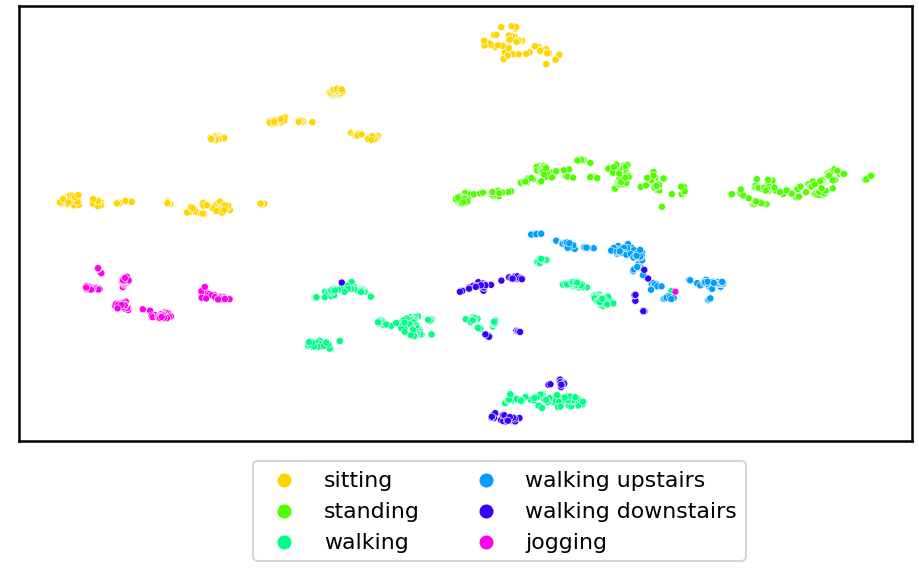

In [ ]:
labels_argmax = np.argmax(np_test[1], axis=1)
unique_labels = np.unique(labels_argmax)

plt.figure(figsize=(16,8))
graph = sns.scatterplot(
    x=tsne_projections[:,0], y=tsne_projections[:,1],
    hue=labels_argmax,
    palette=sns.color_palette("hsv", len(unique_labels)),
    s=50,
    alpha=1.0,
    rasterized=True
)
plt.xticks([], [])
plt.yticks([], [])


plt.legend(loc='lower left', bbox_to_anchor=(0.25, -0.3), ncol=2)
legend = graph.legend_
for j, label in enumerate(unique_labels):
    legend.get_texts()[j].set_text(label_list_full_name[label]) 

### Custom Color maps (Optional)

This section can be run to produce plots where semantically similar classes share similar colors. This requires the definition of a custom mapping of classes to colors.

In [ ]:
# This is used to select colors for labels which are close to each other
# Each pair corresponds to one label class
# i.e. ['null', 'sitting', 'standing', 'walking', 'walking upstairs', 'walking downstairs', 'jogging']
# The first number determines the color map, and the second determines its value along the color map
# So 'sitting', 'standing' will share similar colors, and 'walking', 'walking upstairs', 'walking downstairs' will share another set of similar colors
label_color_spectrum = [(0, 0), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2), (3, 0)] 

# This step generates a list of colors for different categories of activities
# Here we assume 5 categories, and 5 different intesities within each category
major_colors = ['cool', 'Blues', 'Greens', 'Oranges', 'Purples']
color_map_base = dict (
    [((i, j), color) for i, major_color in enumerate(major_colors) for j, color in enumerate(reversed(sns.color_palette(major_color, 5))) ]
)
color_palette = np.array([color_map_base[color_index] for color_index in label_color_spectrum])

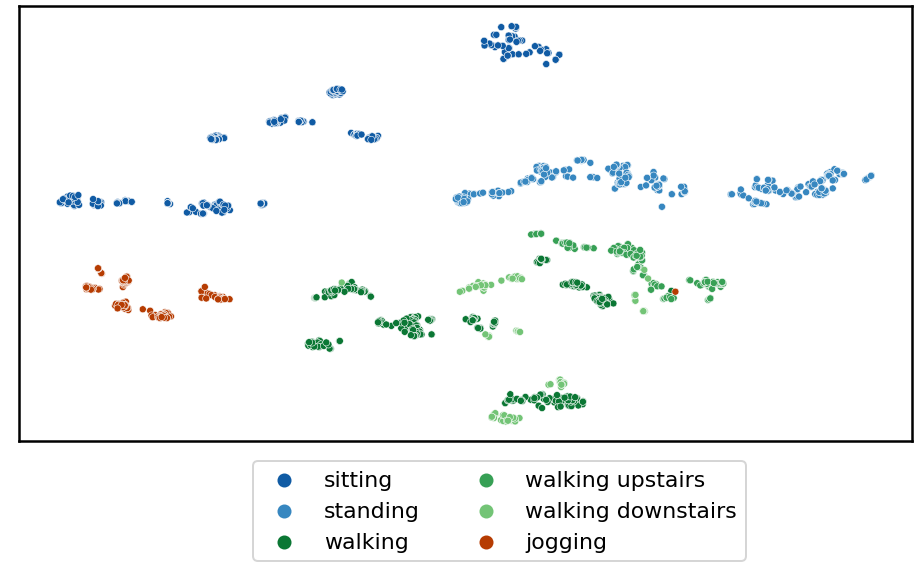

In [ ]:
# This selects the appropriate number of colors to be used in the plot
labels_argmax = np.argmax(np_test[1], axis=1)
unique_labels = np.unique(labels_argmax)

plt.figure(figsize=(16,8))
graph = sns.scatterplot(
    x=tsne_projections[:,0], y=tsne_projections[:,1],
    hue=labels_argmax,
    palette=list(color_palette[unique_labels]),
    s=50,
    alpha=1.0,
    rasterized=True
)
plt.xticks([], [])
plt.yticks([], [])


plt.legend(loc='lower left', bbox_to_anchor=(0.25, -0.3), ncol=2)
legend = graph.legend_
for j, label in enumerate(unique_labels):
    legend.get_texts()[j].set_text(label_list_full_name[label]) 
